In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
np.random.seed(123)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.clf()
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    plt.show()

def evaluate_binary_clf_proba(y_actual, y_prob):
    plt.clf()
    precisions, recalls, thresholds = precision_recall_curve(y_actual, y_prob)
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    fpr, tpr, _ = roc_curve(y_actual, y_prob)
    plt.plot(fpr, tpr, marker='.')
    auc = roc_auc_score(y_actual, y_prob)
    print('auc: ', auc)
    plt.show()

def evaluate_binary_clf_bin(y_actual, y_bin):
    plt.clf()
    print(confusion_matrix(y_actual, y_bin))
    print('precision: ', precision_score(y_actual, y_bin))
    print('recall: ', recall_score(y_actual, y_bin))
    print('f1-score: ', f1_score(y_actual, y_bin))

X, y = make_circles(n_samples=1000, factor=0.5, noise=.1)

fig = plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.title("Dataset")
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()
# Reshape targets to get column vector with shape (n_samples, 1)
y = y[:, np.newaxis]
# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

X_train_s = X_train[:4]
y_train_s = y_train[:4]

<Figure size 800x600 with 1 Axes>

Shape X_train: (750, 2)
Shape y_train: (750, 1)
Shape X_test: (250, 2)
Shape y_test: (250, 1)


In [5]:
X_train.shape, y_train.shape

((750, 2), (750, 1))

In [22]:
#DL implementations: Transpose X, Y and use ReLU as hidden layer activition function
class NeuralNetH1_DL():
    def __init__(self, n_inputs, n_outputs, n_hidden1):
        # Initialize weight matrices and bias vectors
        self.W1 = np.random.randn(n_hidden1, n_inputs)
        self.b1 = np.zeros((n_hidden1, 1))
        self.W2 = np.random.randn(n_outputs, n_hidden1)
        self.b2 = np.zeros((n_outputs, 1))
        
    def sigmoid(self, a):
        return 1 / (1 + np.exp(-a))
    
    def relu(self, a):
        return np.maximum(0, a)
    
    def relu_d(self, a):
        x = a
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
    def forward_pass(self, X):
        H1_i = np.dot(self.W1, X) + self.b1
        H1_o = self.relu(H1_i)
        Y_i = np.dot(self.W2, H1_o) + self.b2
        Y_o = self.sigmoid(Y_i)
        outputs = {
                "H1_o": H1_o,
                "Y_o": Y_o,
                }
        return outputs
    
    def cost(self, y_true, y_predict, n_samples):
        cost = (- 1 / n_samples) * np.sum(y_true * np.log(y_predict) + (1 - y_true) * (np.log(1 - y_predict)))
        cost = np.squeeze(cost)
        assert isinstance(cost, float)

        return cost
    
    def backward_pass(self, X, Y, n_samples, outputs):
        Y_o = outputs['Y_o']
        H1_o = outputs['H1_o']
        dz2 = Y_o - Y
        dW2 = (1 / n_samples) * np.dot(dz2, H1_o.T)
        db2 = (1 / n_samples) * np.sum(dz2, axis = 1, keepdims = True)  
        dz1 = np.dot(self.W2.T, dz2) * self.relu_d(H1_o)
        dW1 = (1 / n_samples) * np.dot(dz1, X.T)
        db1 = (1 / n_samples) * np.sum(dz1, axis = 1, keepdims = True)    
        gradients = {
                "dW2": dW2,
                "db2": db2,
                "dW1": dW1,
                "db1": db1,
                }
        return gradients
    
    def update_weights(self, gradients, eta):
        self.W2 = self.W2 - eta * gradients["dW2"]
        self.b2 = self.b2 - eta * gradients["db2"]
        self.W1 = self.W1 - eta * gradients["dW1"]
        self.b1 = self.b1 - eta * gradients["db1"]

    def train(self, X, y, n_iters=500, eta=0.3):
#         n_samples, _ = X.shape
        _, n_samples = X.shape
        for i in range(n_iters):
            outputs = self.forward_pass(X)
            cost = self.cost(y, outputs['Y_o'], n_samples=n_samples)
            gradients = self.backward_pass(X, y, n_samples, outputs)

            if i % 100 == 0:
#             if i % 1 == 0:
                print(f'Cost at iteration {i}: {np.round(cost, 4)}')
            self.update_weights(gradients, eta)


    def predict(self, X):
        outputs = self.forward_pass(X)
        y_pred = [1 if elem >= 0.5 else 0 for elem in outputs["Y_o"]]
        return np.array(y_pred)[:, np.newaxis]
    
    def predict_proba(self, X):
        outputs = self.forward_pass(X)
        return outputs['Y_o']

In [29]:
n_iters = 1000
learning_rate = 0.1
nn = NeuralNetH1_DL(n_inputs=2, n_outputs=1, n_hidden1=6)
# nn = NeuralNetH2(n_inputs=2, n_outputs=1, n_hidden1=6, n_hidden2=6)
nn.train(X_train.T, y_train.T, n_iters=2000, eta=0.7)
# fig = plt.figure(figsize=(8,6))
# plt.plot(np.arange(n_iters), costs)
# plt.title("Development of cost during training")
# plt.xlabel("Number of iterations")
# plt.ylabel("Cost")
# plt.show()

n_samples, _ = X_train.shape
n_samples_test, _ = X_test.shape

# # y_p_train = nn.predict(X_train)
# y_p_test = nn.predict(X_test.T)

# # evaluate_binary_clf_bin(y_train, y_p_train)
# evaluate_binary_clf_bin(y_test, y_p_test)

# # y_proba_train = nn.predict_proba(X_train)
# y_proba_test = nn.predict_proba(X_test.T)

# # evaluate_binary_clf_proba(y_train, y_proba_train)
# evaluate_binary_clf_proba(y_test, y_proba_test)
# n_test_samples, _ = X_test.shape
# y_predict = nn.predict(X_test.T)
# print(f"Classification accuracy on test set: {(np.sum(y_predict == y_test)/n_test_samples)*100} %")

Cost at iteration 0: 0.7335
Cost at iteration 100: 0.1852
Cost at iteration 200: 0.0803
Cost at iteration 300: 0.0522
Cost at iteration 400: 0.0396
Cost at iteration 500: 0.0325
Cost at iteration 600: 0.0278
Cost at iteration 700: 0.0245
Cost at iteration 800: 0.022
Cost at iteration 900: 0.0201
Cost at iteration 1000: 0.0185
Cost at iteration 1100: 0.0173
Cost at iteration 1200: 0.0162
Cost at iteration 1300: 0.0152
Cost at iteration 1400: 0.0144
Cost at iteration 1500: 0.0137
Cost at iteration 1600: 0.013
Cost at iteration 1700: 0.0125
Cost at iteration 1800: 0.0119
Cost at iteration 1900: 0.0115


In [27]:
class NeuralNetH1():
    
    def __init__(self, n_inputs, n_outputs, n_hidden1):
        # Initialize weight matrices and bias vectors
        self.W0 = np.random.randn(n_inputs, n_hidden1)
        self.b0 = np.zeros((1, n_hidden1))
        self.W1 = np.random.randn(n_hidden1, n_outputs)
        self.b1 = np.zeros((1, n_outputs))

    def sigmoid(self, a):
        return 1 / (1 + np.exp(-a))

    def forward_pass(self, X):
        # Compute activations and outputs of hidden units: H = sigmoid(W_0*X + b0)
        H1_i = np.dot(X, self.W0) + self.b0
        H1_o = self.sigmoid(H1_i)
        # Compute activations and outputs of output units: Y = sigmoid(W_1*H + b1)
        Y_i = np.dot(H1_o, self.W1) + self.b1
        Y_o = self.sigmoid(Y_i)

        outputs = {
                "H1_o": H1_o,
                "Y_o": Y_o,
                }

        return outputs

    def cost(self, y_true, y_predict, n_samples):
        """
        Computes and returns the cost over all examples
        """
        # same cost function as in logistic regression
        cost = (- 1 / n_samples) * np.sum(y_true * np.log(y_predict) + (1 - y_true) * (np.log(1 - y_predict)))
        cost = np.squeeze(cost)
        assert isinstance(cost, float)

        return cost

    def backward_pass(self, X, Y, n_samples, outputs):
        Y_o = outputs['Y_o']
        H1_o = outputs['H1_o']
        
        # e2 = Y_o - Y
        # e1 = W1*e2*H1*(1-H1)        -----    VERY IMPORTANT: *h2*(1-h2) is SCALING
        # dJ/dw1 = H1*e2
        # dJ/dw0 = X*e1
        
        e2 = Y_o - Y
        dW1 = (1 / n_samples) * np.dot(H1_o.T, e2)
        db1 = (1 / n_samples) * np.sum(e2)
# -----VERY IMPORTANT: *H1*(1-H1) is SCALING NOT PRODUCTION: *H1*(1-H1) √ | .dot(H1.dot(1-H1)) X
#         print(Y_o.shape)
#         print(Y)
#         print(e2.shape)
#         print(self.W1.shape)
#         print(H1_o.shape)
        e1 = (np.dot(e2, self.W1.T)) * H1_o * (1 - H1_o)

        dW0 = (1 / n_samples) * np.dot(X.T, e1)
        db0 = (1 / n_samples) * np.sum(e1)

        gradients = {
                "dW1": dW1,
                "db1": db1,
                "dW0": dW0,
                "db0": db0,
                }

        return gradients

    def update_weights(self, gradients, eta):
        self.W1 = self.W1 - eta * gradients["dW1"]
        self.b1 = self.b1 - eta * gradients["db1"]
        
        self.W0 = self.W0 - eta * gradients["dW0"]
        self.b0 = self.b0 - eta * gradients["db0"]

    def train(self, X, y, n_iters=500, eta=0.3):
        n_samples, _ = X.shape

        for i in range(n_iters):
            outputs = self.forward_pass(X)
            cost = self.cost(y, outputs['Y_o'], n_samples=n_samples)
            gradients = self.backward_pass(X, y, n_samples, outputs)

            if i % 100 == 0:
#             if i % 1 == 0:
                print(f'Cost at iteration {i}: {np.round(cost, 4)}')
            self.update_weights(gradients, eta)


    def predict(self, X):
        outputs = self.forward_pass(X)
        y_pred = [1 if elem >= 0.5 else 0 for elem in outputs["Y_o"]]
        return np.array(y_pred)[:, np.newaxis]
    def predict_proba(self, X):
        outputs = self.forward_pass(X)
        return outputs['Y_o']

In [46]:
class NeuralNetH2():
    
    def __init__(self, n_inputs, n_outputs, n_hidden1, n_hidden2):
        # Initialize weight matrices and bias vectors
        self.W0 = np.random.randn(n_inputs, n_hidden1)
        self.b0 = np.zeros((1, n_hidden1))
        self.W1 = np.random.randn(n_hidden1, n_hidden2)
        self.b1 = np.zeros((1, n_hidden2))
        self.W2 = np.random.randn(n_hidden2, n_outputs)
        self.b2 = np.zeros((1, n_outputs))

    def sigmoid(self, a):
        return 1 / (1 + np.exp(-a))

    def forward_pass(self, X):
        # Compute activations and outputs of hidden units: H = sigmoid(W_0*X + b0)
        H1_i = np.dot(X, self.W0) + self.b0
        H1_o = self.sigmoid(H1_i)
        # Compute activations and outputs of output units: Y = sigmoid(W_1*H + b1)
        H2_i = np.dot(H1_o, self.W1) + self.b1
        H2_o = self.sigmoid(H2_i)
        
        Y_i = np.dot(H2_o, self.W2) + self.b2
        Y_o = self.sigmoid(Y_i)

        outputs = {
                "H1_o": H1_o,
                "H2_o": H2_o,
                "Y_o": Y_o,
                }

        return outputs

    def cost(self, y_true, y_predict, n_samples):
        """
        Computes and returns the cost over all examples
        """
        # same cost function as in logistic regression
        cost = (- 1 / n_samples) * np.sum(y_true * np.log(y_predict) + (1 - y_true) * (np.log(1 - y_predict)))
        cost = np.squeeze(cost)
        assert isinstance(cost, float)

        return cost

    def backward_pass(self, X, Y, n_samples, outputs):
        Y_o = outputs['Y_o']
        H2_o = outputs['H2_o']
        H1_o = outputs['H1_o']
        
        # e2 = Y_o - Y
        # e1 = W1*e2*H1*(1-H1)        -----    VERY IMPORTANT: *h2*(1-h2) is SCALING
        # dJ/dw1 = H1*e2
        # dJ/dw0 = X*e1
        
        e3 = Y_o - Y
        dW2 = (1 / n_samples) * np.dot(H2_o.T, e3)
        db2 = (1 / n_samples) * np.sum(e3)
# -----VERY IMPORTANT: *H1*(1-H1) is SCALING NOT PRODUCTION: *H1*(1-H1) √ | .dot(H1.dot(1-H1)) X
        e2 = (np.dot(e3, self.W2.T)) * H2_o * (1 - H2_o)
        dW1 = (1 / n_samples) * np.dot(H1_o.T, e2)
        db1 = (1 / n_samples) * np.sum(e2)

        e1 = (np.dot(e2, self.W1.T)) * H1_o * (1 - H1_o)
        dW0 = (1 / n_samples) * np.dot(X.T, e1)
        db0 = (1 / n_samples) * np.sum(e1)
        
        gradients = {
                "dW2": dW2,
                "db2": db2,
                "dW1": dW1,
                "db1": db1,
                "dW0": dW0,
                "db0": db0,
                }

        return gradients

    def update_weights(self, gradients, eta):
        self.W2 = self.W2 - eta * gradients["dW2"]
        self.b2 = self.b2 - eta * gradients["db2"]
        
        self.W1 = self.W1 - eta * gradients["dW1"]
        self.b1 = self.b1 - eta * gradients["db1"]
        
        self.W0 = self.W0 - eta * gradients["dW0"]
        self.b0 = self.b0 - eta * gradients["db0"]

    def train(self, X, y, n_iters=500, eta=0.3):
        n_samples, _ = X.shape

        for i in range(n_iters):
            outputs = self.forward_pass(X)
            cost = self.cost(y, outputs['Y_o'], n_samples=n_samples)
            gradients = self.backward_pass(X, y, n_samples, outputs)

            if i % 100 == 0:
                print(f'Cost at iteration {i}: {np.round(cost, 4)}')
            self.update_weights(gradients, eta)


    def predict(self, X):
        outputs = self.forward_pass(X)
        y_pred = [1 if elem >= 0.5 else 0 for elem in outputs["Y_o"]]
        return np.array(y_pred)[:, np.newaxis]
    def predict_proba(self, X):
        outputs = self.forward_pass(X)
        return outputs['Y_o']

Cost at iteration 0: 0.694
Cost at iteration 100: 0.6876
Cost at iteration 200: 0.6692
Cost at iteration 300: 0.6315
Cost at iteration 400: 0.5807
Cost at iteration 500: 0.5366
Cost at iteration 600: 0.49
Cost at iteration 700: 0.4169
Cost at iteration 800: 0.3277
Cost at iteration 900: 0.2629
Cost at iteration 1000: 0.2239
Cost at iteration 1100: 0.1981
Cost at iteration 1200: 0.1798
Cost at iteration 1300: 0.1662
Cost at iteration 1400: 0.1558
Cost at iteration 1500: 0.1476
Cost at iteration 1600: 0.1409
Cost at iteration 1700: 0.1353
Cost at iteration 1800: 0.1305
Cost at iteration 1900: 0.1264
[[119   2]
 [  5 124]]
precision:  0.9841269841269841
recall:  0.9612403100775194
f1-score:  0.9725490196078431


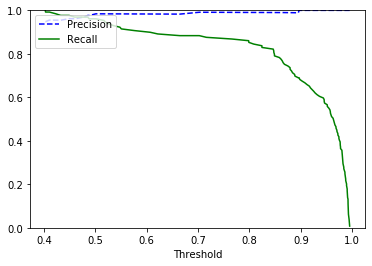

auc:  0.9953872765712088


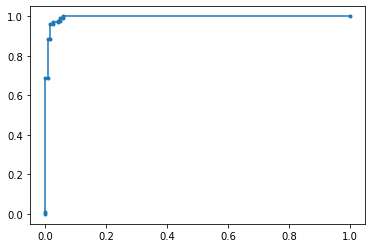

Classification accuracy on test set: 97.2 %


In [28]:
n_iters = 1000
learning_rate = 0.1
nn = NeuralNetH1(n_inputs=2, n_outputs=1, n_hidden1=6)
# nn = NeuralNetH2(n_inputs=2, n_outputs=1, n_hidden1=6, n_hidden2=6)
nn.train(X_train, y_train, n_iters=2000, eta=0.7)
# fig = plt.figure(figsize=(8,6))
# plt.plot(np.arange(n_iters), costs)
# plt.title("Development of cost during training")
# plt.xlabel("Number of iterations")
# plt.ylabel("Cost")
# plt.show()

n_samples, _ = X_train.shape
n_samples_test, _ = X_test.shape

# y_p_train = nn.predict(X_train)
y_p_test = nn.predict(X_test)

# evaluate_binary_clf_bin(y_train, y_p_train)
evaluate_binary_clf_bin(y_test, y_p_test)

# y_proba_train = nn.predict_proba(X_train)
y_proba_test = nn.predict_proba(X_test)

# evaluate_binary_clf_proba(y_train, y_proba_train)
evaluate_binary_clf_proba(y_test, y_proba_test)
n_test_samples, _ = X_test.shape
y_predict = nn.predict(X_test)
print(f"Classification accuracy on test set: {(np.sum(y_predict == y_test)/n_test_samples)*100} %")

# X_temp, y_temp = make_circles(n_samples=60000, noise=.5)
# y_predict_temp = nn.predict(X_temp)
# y_predict_temp = np.ravel(y_predict_temp)

# fig = plt.figure(figsize=(8,12))
# ax = fig.add_subplot(2,1,1)
# plt.scatter(X[:,0], X[:,1], c=y)
# plt.xlim([-1.5, 1.5])
# plt.ylim([-1.5, 1.5])
# plt.xlabel("First feature")
# plt.ylabel("Second feature")
# plt.title("Training and test set")

# ax = fig.add_subplot(2,1,2)
# plt.scatter(X_temp[:,0], X_temp[:,1], c=y_predict_temp)
# plt.xlim([-1.5, 1.5])
# plt.ylim([-1.5, 1.5])
# plt.xlabel("First feature")
# plt.ylabel("Second feature")
# plt.title("Decision boundary")

In [ ]:
# ### Combining W & b: somewhere buggy
# class NeuralNetwork:
    
#     def __init__(self):
#         pass

#     def sigmoid(self, z):
#         return 1 / (1 + np.exp(-z))
    
#     def append_bias(self, X):
#         n_samples, n_features = X.shape
#         ones = np.ones(shape=(n_samples, 1))
#         X1 = np.concatenate((X, ones),axis = 1)
#         return X1
    
#     def predict(self, X):
#         """
#         Computes and returns network predictions for given dataset
#         """
#         X1 = self.append_bias(X)
#         h_o, y_o = self.forward_pass(X1)
#         y_bin = [1 if elem >= 0.5 else 0 for elem in y_o]

#         return np.array(y_bin)[:, np.newaxis]
    
#     def predict_proba(self, X):
#         X1 = self.append_bias(X)
#         h_o, y_o = self.forward_pass(X1)
#         print(h_o)
#         return y_o
    
#     def forward_pass(self, X1):
        
#         """
#         Propagates the given input X forward through the net.
#         """
#         # Compute activations and outputs of hidden units
        
#         h_i = np.dot(X1, self.w1)
#         h_o = self.append_bias(self.sigmoid(h_i))
# #         h_o = self.sigmoid(h_i)

#         y_i = np.dot(h_o, self.w2)
#         y_o = self.sigmoid(y_i)
#         self.debug = False
#         if self.debug:
#             print(X1.shape)
#             print(self.w1.shape)
#             print(h_i.shape)
#             print(h_o.shape)
#             print(self.w2.shape)
#             print(y_i.shape)
#             print(y_o.shape)
        
#         return h_o, y_o
    
#     def train_gradient_descent(self, X, y, learning_rate=0.01, n_iters=100):
#         # Step 0: Initialize the parameters
#         # 3 layers: w1, w2
#         n_samples, n_features = X.shape
#         X1 = self.append_bias(X)   

#         nodes_num_layer1 = 6
        
#         self.debug = False
#         self.w1 = np.random.rand(n_features + 1, nodes_num_layer1)
# #         print('W1', w1.shape)
        
#         # layer 2 parameter number can be configed 
#         self.w2 = np.random.rand(nodes_num_layer1 + 1, 1)
    
#         costs = []
#         # Step 1: Loop until iterate enoughf
    
#         for k in range(n_iters):
#             # forward predict impls
#             h_o, y_o = self.forward_pass(X1)
            
#             # e3 = y - yr
#             # e2 = w2*e3*h2*(1-h2)        -----    VERY IMPORTANT: *h2*(1-h2) is SCALING
#             # dJ/dw2 = h2*e3
#             # dJ/dw1 = h1*e2
            
#             e3 = y_o - y
# #             e2 = np.dot(np.dot(e3, self.w2.T), np.dot(h_o.T, 1 - h_o))
# #             m, n = h_o.shape
# #             h_o_S = h_o[:,:n]
#             e2 = np.dot(e3, self.w2.T) * h_o * (1 - h_o)
        
# #             print(h_o)
# #             print(1-h_o)
# #             print(np.dot(h_o.T, 1-h_o))
#             # Step 2: Compute cost over training set
#             cost = -(1 / n_samples) * np.sum(y * np.log(y_o) + (1 - y) * np.log(1 - y_o))
#             costs.append(cost)
#             if k % (n_iters / 10) == 0:
#                 print(f"Cost at iteration {k}: {cost}")
#             # Step 3: Compute the gradients
#             dJ_dw2 = 1.0 / n_samples * np.dot(h_o.T, e3)

#             m, n = w1.shape
#             dJ_dw1 = 1.0 / n_samples * np.dot(X1.T, e2[:,:n])

# #             gradient = get_gradient()
#             # Step 4: Update the parameters

#             if self.debug:
#                 print(e3.shape)
#                 print(self.w2.shape)
#                 print(h_o.shape)
#                 print((1-h_o).shape)
#                 print(e2.shape)
#                 print(dJ_dw2.shape)
#                 print(dJ_dw1.shape)
                
#             self.w2 = self.w2 - learning_rate * dJ_dw2
#             self.w1 = self.w1 - learning_rate * dJ_dw1
#         return self.w1, self.w2, costs